# Processing GCB
This script uses dask to process GCB models. It decomposes using STL and calculates statistics

## 0. Start the DASK client
This inititalizes and starts the dask client. 
- `client.restart()` will restart the client
- `client.close()` will close the client

In [1]:
from distributed import Client

In [2]:
# 1. Intitialize the dask client
client = Client(n_workers=8)
# 2. Start the dask client. 
client

/home/gloege/.conda/envs/tensorflow/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:41003 Dashboard: http://127.0.0.1:33094/status,Cluster Workers: 8 Cores: 48 Memory: 269.92 GB


In [3]:
%matplotlib inline
import xarray as xr
import xarray.ufuncs as xu
import numpy as np
import scipy
import scipy.io
from scipy.stats import stats
#from processing import processing as pr
from skill_metrics import skill_metrics as sk
import decompose as stl

In [4]:
client.restart()

Client Scheduler: tcp://127.0.0.1:41770 Dashboard: http://127.0.0.1:32919/status,Cluster Workers: 8 Cores: 48 Memory: 269.92 GB


In [3]:
client.close()

In [21]:
# these are notebooks with function definitions
%run _define_GCB_processing.ipynb

In [5]:
###======================================
### Define directories
###====================================== 
dir_raw = '/local/data/artemis/workspace/gloege/SOCAT-LE/data/raw'
dir_clean = '/local/data/artemis/workspace/gloege/SOCAT-LE/data/clean'

In [ ]:
## data directory
dir_data = '/local/data/artemis/workspace/gloege/LDEO-FFN/data/GCB_models/GCB_cut'

## model dictionary
dict_model = {'CNRM-ESM':f'{dir_data}/CNRM-ESM2_spco2_1x1_198201-201712.nc',
             'CCSM-BEC':f'{dir_data}/CCSM-BEC_spco2_1x1_198201-201712.nc',
             'MPI':f'{dir_data}/MPI_spco2_1x1_198201-201712.nc',
             'NEMO-planktom':f'{dir_data}/NEMO-planktom_spco2_1x1_198201-201712.nc',
             'NorESM':f'{dir_data}/NorESM_spco2_1x1_198201-201712.nc',
             'REcoM_jra':f'{dir_data}/REcoM_jra_spco2_1x1_198201-201712.nc',
             'IPSL-PISCES':f'{dir_data}/IPSL-PISCES_spco2_1x1_198201-201512.nc'}

# 1. Decompose pCO2

In [9]:
###=================================================================
### LE_model: ['CESM', 'GFDL', 'MPI', CanESM2]
### model_or_recon: ['MODEL', 'SOMFFN', 'UEASI']
###=================================================================

# Output directory where decomposition stored
dir_out = f'/local/data/artemis/workspace/gloege/LDEO-FFN/data/GCB_models/GCB_decompose'

# Print diectory in log file
f = open("/home/gloege/log.decompose_GCB.txt", "a")
f.write(f"Output directory : {dir_out} \n")
f.close()
    
###======================================
### Load data
### client.map    --> These results live on distributed workers.
### client.submit --> We can submit tasks on futures. 
###                   The function will go to the machine where 
###                   the futures are stored and run on the result 
###                   once it has completed.
###======================================


## Run the decompose_pco2 function
fut = client.map(decompose_GCB, 
                 list(dict_model.keys()), 
                 list(dict_model.values()), 
                 tuple(np.repeat(dir_out, len(dict_model))))
client.gather(fut)

del fut

## Completion statement
print('Complete!!')
f = open("/home/gloege/log.decompose_GCB.txt", "a")
f.write(f"Complete! \n")
f.close()

Complete!!


In [10]:
client.close()

# Decompose SOM-FFN

In [25]:
dir_prods = '/local/data/artemis/workspace/gloege/products'

In [26]:
dir_prods = '/local/data/artemis/workspace/gloege/products'
ds = xr.open_dataset(f'{dir_prods}/spco2_1982-2015_MPI_SOM-FFN_v2016.nc')
ds['spco2_smoothed']

In [30]:
###======================================
### Load dataset
###======================================
#ds = xr.open_dataset(fl_path)

### Make sure correct order
#ds = ds.transpose('time', 'lat', 'lon')

dir_prods = '/local/data/artemis/workspace/gloege/products'
ds = xr.open_dataset(f'{dir_prods}/spco2_1982-2015_MPI_SOM-FFN_v2016.nc')

###======================================
### STL Decomposition
###======================================
### 0. Load raw data
print('copying data')
data = ds[f'spco2_smoothed'].copy()

### 1. Detrend it 
print('detrending data')
data_detrend = stl.detrend(data, dim='time')

### 2. Remove seasonal cycle
# 2.1 -- seasonal cycle
print('remove seasonal cycle')
data_seasonal = stl.seasonal_cycle(data_detrend, dim='time', period=12)

# 2.2 -- de-season the data
print('deseason')
data_deseason = data_detrend - data_seasonal

### 3. calculate the LOWESS
print('lowess....')
data_lowess = stl.lowess(data_deseason, dim='time', lo_pts=12*10, lo_delta=0.01)

### 4. Residual term -- not explained by trend or seasonal cycle
print('residual')
data_residual = data_deseason - data_lowess

### Low frequency of residual
print('residual lowess....')
data_residual_low = stl.lowess(data_residual, dim='time', lo_pts=12, lo_delta=0.01)

###======================================
### Return dataset
###======================================
print('return dataset')
ds_out = xr.Dataset(
    {    
    'spco2': (['time', 'lat', 'lon'], data.transpose('time','lat','lon') ),
    'spco2_detrend': (['time', 'lat', 'lon'], data_detrend.transpose('time','lat','lon') ),
    'spco2_dec': (['time','lat', 'lon'], data_lowess.transpose('time','lat','lon') ),
    'spco2_seasonal': (['time','lat', 'lon'], data_seasonal.transpose('time','lat','lon') ),
    'spco2_residual': (['time','lat', 'lon'], data_residual.transpose('time','lat','lon') ),
    'spco2_residual_low': (['time','lat', 'lon'], data_residual_low.transpose('time','lat','lon') ),
    },

    coords={
    'time': (['time'], ds['time']),
    'lat': (['lat'], ds['lat']),
    'lon': (['lon'], ds['lon']),
    })

### save file
print('saving data')
ds_out.to_netcdf(f'/local/data/artemis/workspace/gloege/products/SOM-FFN_decomposed/SOM-FFNv2016_decomposed_1982-2015.nc')

print('complete!!')

copying data
detrending data
remove seasonal cycle
deseason
lowess....
residual
residual lowess....
return dataset
saving data
complete!!


# Statistics

In [19]:
#ds_som = xr.open_dataset(fl_som)
#ds_mod = xr.open_dataset(dict_model_decomposed['CNRM-ESM'])
#len(ds_mod.time)

In [22]:
## SOM-FFN file path
dir_prods = '/local/data/artemis/workspace/gloege/products/SOM-FFN_decomposed'
fl_som = f'{dir_prods}/SOM-FFNv2016_decomposed_1982-2015.nc'


### Dictionary of model diectories
dir_model = '/local/data/artemis/workspace/gloege/LDEO-FFN/data/GCB_models/GCB_decompose'
dict_model_decomposed = {'CNRM-ESM':f'{dir_model}/CNRM-ESM_spco2-decompose_1x1_198201-201712.nc',
             'CCSM-BEC':f'{dir_model}/CCSM-BEC_spco2-decompose_1x1_198201-201712.nc',
             'MPI':f'{dir_model}/MPI_spco2-decompose_1x1_198201-201712.nc',
             'NEMO-planktom':f'{dir_model}/NEMO-planktom_spco2-decompose_1x1_198201-201712.nc',
             'NorESM':f'{dir_model}/NorESM_spco2-decompose_1x1_198201-201712.nc',
             'REcoM_jra':f'{dir_model}/REcoM_jra_spco2-decompose_1x1_198201-201712.nc',
             'IPSL-PISCES':f'{dir_model}/IPSL-PISCES_spco2-decompose_1x1_198201-201712.nc'}

### Output directory where decomposition stored
dir_out = f'/local/data/artemis/workspace/gloege/LDEO-FFN/data/GCB_models/GCB_stats'

### Print diectory in log file
f = open("/home/gloege/log.decompose_GCB_stats.txt", "a")
f.write(f"Output directory : {dir_out} \n")
f.close()
    
###======================================
### Load data
### client.map    --> These results live on distributed workers.
### client.submit --> We can submit tasks on futures. 
###                   The function will go to the machine where 
###                   the futures are stored and run on the result 
###                   once it has completed.
###======================================
## Run the decompose_pco2 function
fut = client.map(calculate_GCB_statistics, 
                 list(dict_model_decomposed.keys()), 
                 list(dict_model_decomposed.values()), 
                 tuple(np.repeat(fl_som, len(dict_model_decomposed))),
                 tuple(np.repeat(dir_out, len(dict_model_decomposed))))
client.gather(fut)

del fut

## Completion statement
print('Complete!!')
f = open("/home/gloege/log.decompose_GCB_stats.txt", "a")
f.write(f"Complete! \n")
f.close()

Complete!!


# Look at stats

In [24]:
fl_path = '/local/data/artemis/workspace/gloege/LDEO-FFN/data/GCB_models/GCB_stats'
ds = xr.open_mfdataset(f'{fl_path}/*.nc', concat_dim='ensemble')

In [27]:
import matplotlib.pyplot as plt

In [29]:
import cmocean as cm

In [31]:
cm.cm.balance

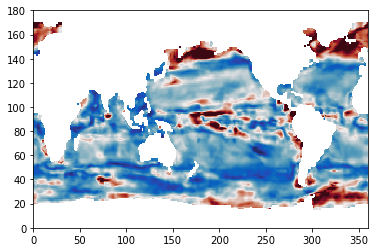

In [53]:
plt.pcolor(ds['std-star_seasonal'].mean('ensemble'), cmap=cm.cm.balance, vmin=-1, vmax=1)

In [ ]:
sk.std_star()

# Terse look at output

In [36]:
data_dir='/local/data/artemis/workspace/gloege/LDEO-FFN/data/GCB_models/GCB_decompose'
ds = xr.open_dataset(f'{data_dir}/MPI_spco2-decompose_1x1_198201-201712.nc')

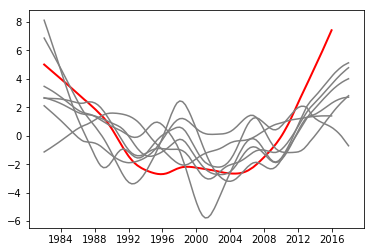

In [47]:
data_dir='/local/data/artemis/workspace/gloege/LDEO-FFN/data/GCB_models/GCB_decompose'
ds1 = xr.open_dataset(f'{data_dir}/CCSM-BEC_spco2-decompose_1x1_198201-201712.nc')
ds2 = xr.open_dataset(f'{data_dir}/CNRM-ESM_spco2-decompose_1x1_198201-201712.nc')
ds3 = xr.open_dataset(f'{data_dir}/IPSL-PISCES_spco2-decompose_1x1_198201-201712.nc')
ds4 = xr.open_dataset(f'{data_dir}/MPI_spco2-decompose_1x1_198201-201712.nc')
ds5 = xr.open_dataset(f'{data_dir}/NEMO-planktom_spco2-decompose_1x1_198201-201712.nc')
ds6 = xr.open_dataset(f'{data_dir}/NorESM_spco2-decompose_1x1_198201-201712.nc')
ds7 = xr.open_dataset(f'{data_dir}/REcoM_jra_spco2-decompose_1x1_198201-201712.nc')

plt.plot(ds_out['time'], ds_out['spco2_dec'].sel(lat=20, lon=-150, method='nearest'), color='r', linewidth=2)

plt.plot(ds1['time'], ds1['spco2_dec'].sel(lat=20, lon=360-150, method='nearest'), color=[0.5,0.5,0.5])

plt.plot(ds2['time'], ds2['spco2_dec'].sel(lat=20, lon=360-150, method='nearest'), color=[0.5,0.5,0.5])

plt.plot(ds3['time'], ds3['spco2_dec'].sel(lat=20, lon=360-150, method='nearest'), color=[0.5,0.5,0.5])

plt.plot(ds4['time'], ds4['spco2_dec'].sel(lat=20, lon=360-150, method='nearest'), color=[0.5,0.5,0.5])

plt.plot(ds5['time'], ds5['spco2_dec'].sel(lat=20, lon=360-150, method='nearest'), color=[0.5,0.5,0.5])

plt.plot(ds6['time'], ds6['spco2_dec'].sel(lat=20, lon=360-150, method='nearest'), color=[0.5,0.5,0.5])
plt.plot(ds7['time'], ds7['spco2_dec'].sel(lat=20, lon=360-150, method='nearest'), color=[0.5,0.5,0.5])

In [12]:
data_dir='/local/data/artemis/workspace/gloege/LDEO-FFN/data/GCB_models/GCB_decompose'
ds = xr.open_dataset(f'{data_dir}/CCSM-BEC_spco2-decompose_1x1_198201-201712.nc')

In [15]:
import matplotlib.pyplot as plt

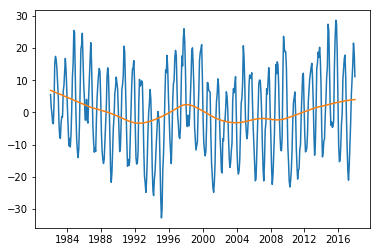

In [24]:
plt.plot(ds['time'], ds['spco2_detrend'].sel(lat=20, lon=360-150, method='nearest'))
plt.plot(ds['time'], ds['spco2_dec'].sel(lat=20, lon=360-150, method='nearest'))